https://www.youtube.com/watch?v=rdR2fNDq6v0&t=531s

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


# 1. Road Data

In [3]:
df=pd.read_csv('https://raw.githubusercontent.com/sm-joo/sm-joo/master/DEXKOUS.csv', parse_dates=['DATE'], index_col='DATE')

In [4]:
df.columns =['KOUS']
df['KOUS'].replace('.', '', inplace =True)
df['KOUS'] = pd.to_numeric(df['KOUS'])
df['KOUS'].fillna(method = 'ffill', inplace = True)

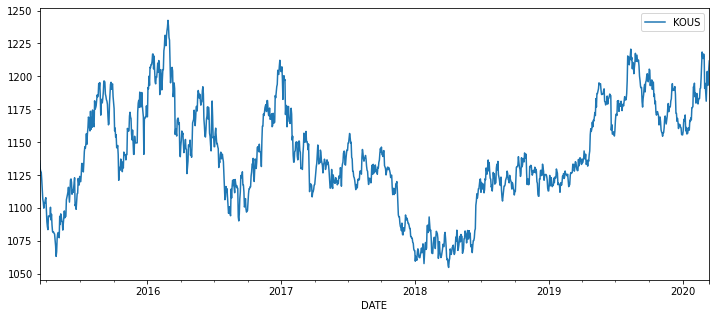

In [5]:
df.plot(figsize = (12, 5))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1306 entries, 2015-03-13 to 2020-03-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KOUS    1306 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB


2019년도만 살펴보자

In [7]:
df = df[(df.index>'2019-01-01') & (df.index < '2020-01-01')]

# 2. Stationary한 데이터 여부 확인하기

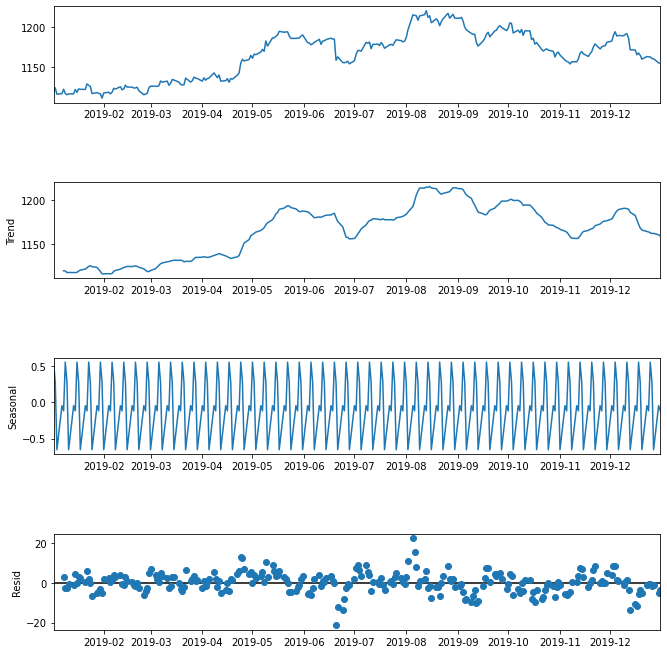

In [8]:
result = seasonal_decompose(df, model = 'additive', two_sided = False)
fig = result.plot()
fig.set_size_inches(10,10)
plt.show()

해당 기법을 어느정도 신뢰할 수 있을지 모르지만 계절성이 있고 5~6월과 7월의 잔차가 많아 보인다.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


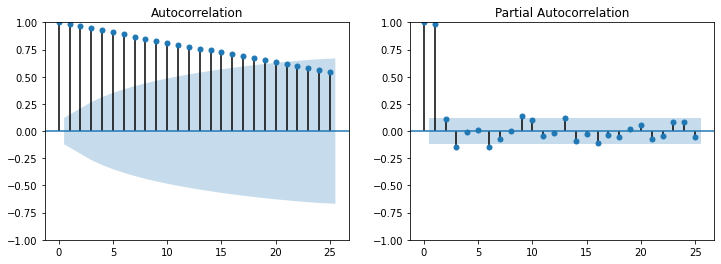

In [9]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 시각화
# subplot생성
fig, ax = plt.subplots(1,2 , figsize = (12,4))

# acf plot
plot_acf(df, ax = ax[0])

# pacf plot
plot_pacf(df, ax= ax[1])
plt.show()

두가지 도표를 추가로 확인해본 결과 정상성을 만족하지않는 nonstationary한 데이터인것같다.

# 3. 데이터셋 분리

In [10]:
train_df, test_df = train_test_split(df, test_size = 0.2, shuffle = False)

# ARIMA(p,k,q) => k 결정

In [14]:
adfuller(train_df.KOUS)

(-1.5116465046170995,
 0.52774231404394,
 2,
 205,
 {'1%': -3.4626576734812318,
  '10%': -2.5743412314098753,
  '5%': -2.8757444215841326},
 1160.1362840640052)

위에서acf,pacf도표를 통해 non-stationary 하다는것을 확인했고 adfuller를통해 p-value까지 확인 해 보았다.


p-valuer가가 0.36으로 귀무가설이이 기각되지 않는다 -> 안정적이지 않다 따라서 차분이 필요하다

In [16]:
adfuller(train_df.KOUS.diff().dropna())

(-9.672174308592568,
 1.2683068272424294e-16,
 1,
 205,
 {'1%': -3.4626576734812318,
  '10%': -2.5743412314098753,
  '5%': -2.8757444215841326},
 1154.8592888585188)

In [20]:
diff_train_df = train_df.KOUS.diff().dropna()

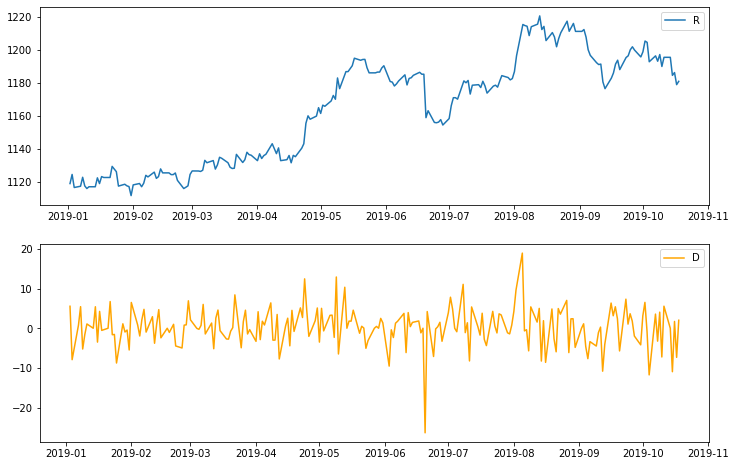

In [26]:
plt.figure(figsize= (12,8))
plt.subplot(211)
plt.plot(train_df)
plt.legend('RawData')
plt.subplot(212)
plt.plot(diff_train_df, 'orange')
plt.legend('DifferencedData')
plt.show()

1회 차분했을때 평균과 분산이 훨씬 좋아진모습이다.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


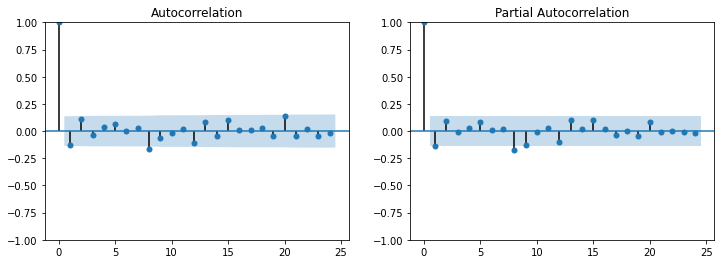

In [33]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 시각화
# subplot생성
fig, ax = plt.subplots(1,2 , figsize = (12,4))

# acf plot
plot_acf(diff_train_df, ax = ax[0])

# pacf plot
plot_pacf(diff_train_df, ax= ax[1])
plt.show()

acf도표와, pacf도표또한 훨씬 안정적인 모양이다.

# ARIMA(p,k,q) => p, q 결정

## Graphical method를를 통해 계략적인 모델링 산정

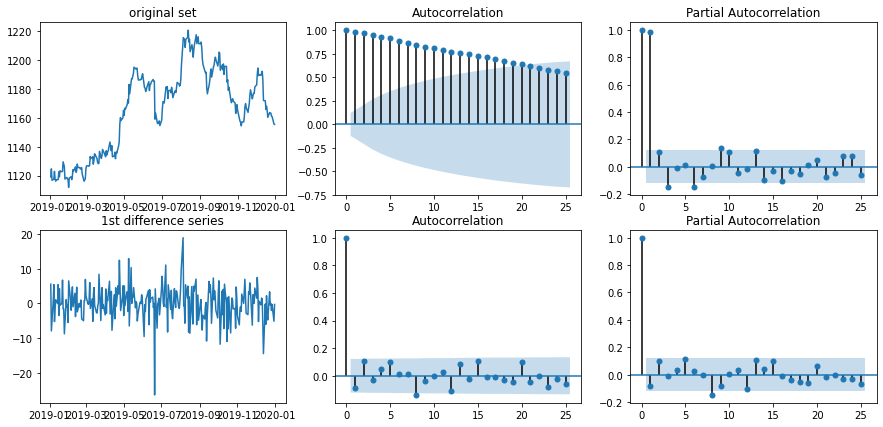

In [ ]:
figure, axes =plt.subplots(2, 3, figsize =(15,7))
axes[0,0].plot(df.KOUS)
axes[0,0].set_title('original set')
axes[1,0].plot(df.KOUS.diff())
axes[1,0].set_title('1st difference series')
plot_acf(df.KOUS, axes[0,1])
plot_pacf(df.KOUS, axes[0,2])
plot_acf(df.KOUS.diff().dropna(), axes[1,1])
plot_pacf(df.KOUS.diff().dropna(), axes[1,2])
plt.show()

```
AR차수는 PACF도표를 통해 확인하고 MA차수는 ARMA()의 차분한 것의 ACF도표를 통해 차수를 확인한다.
AR차수는 1차 ~ 3차
MA차수는 0차 ~ 2차
```

# ARIMA 예측 모델링


파라미터 설명
- order : AR차수, 차분횟수, MA차수
- freq : 날짜 

    'B' - business day, ie., Mon. - Fri.
    'D' - daily
    'W' - weekly
    'M' - monthly
    'A' - annual
    'Q' - quarterly
- trend : 상수항 포함여부, 'c'(constant) or 'nc'(no constant) -> 'c'를 했을때 constant가 0.05보다 크게나온다면 nc를 하는게 좋다. 

In [ ]:
# 상수항 포함여부 확인해보기
model = ARIMA(df.KOUS, order = (3,1,2), freq = 'B') # 환율데이터는 주말에는 나오지 않고 평일에만 나오기 때문에 buisiness date를 사용
model_fit = model.fit(trend = 'c')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -768.584
Method:                       css-mle   S.D. of innovations              4.675
Date:                Fri, 08 Jul 2022   AIC                           1551.167
Time:                        10:38:25   BIC                           1576.065
Sample:                    01-03-2019   HQIC                          1561.178
                         - 12-31-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1360      0.275      0.495      0.621      -0.403       0.674
ar.L1.D.KOUS    -0.2885      0.064     -4.516      0.000      -0.414      -0.163
ar.L2.D.KOUS    -0.9560      0.030    -31.941      0.000      -1.015      -0.897
ar.L3.D.KOUS    -0.0894      0.064     -1.401      0.162      -0.214       0.036
ma.L1.D.KOUS     0.2069      0.016     12.541      0.000       0.175       0.239
ma.L2.D.KOUS     0.9999      0.019     52.721      0.000       0.963       1.037
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1030           -1.0276j            1.0327           -0.2659
AR.2           -0.1030           +1.0276j            1.0327            0.2659
AR.3          -10.4909           -0.0000j           10.4909           -0.5000
MA.1           -0.1035           -0.9947j            1.0000           -0.2665
MA.2           -0.1035           +0.9947j            1.0000            0.2665
-----------------------------------------------------------------------------
"""

constant(상수항)은 귀무가설을 기각하여 변수가 필요없어 보인다.

In [ ]:
model = ARIMA(df.KOUS, order = (3,1,2), freq = 'B') # 환율데이터는 주말에는 나오지 않고 평일에만 나오기 때문에 buisiness date를 사용
model_fit = model.fit(trend = 'nc')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -768.706
Method:                       css-mle   S.D. of innovations              4.677
Date:                Fri, 08 Jul 2022   AIC                           1549.412
Time:                        10:39:06   BIC                           1570.753
Sample:                    01-03-2019   HQIC                          1557.992
                         - 12-31-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -0.2878      0.064     -4.504      0.000      -0.413      -0.163
ar.L2.D.KOUS    -0.9557      0.030    -31.909      0.000      -1.014      -0.897
ar.L3.D.KOUS    -0.0885      0.064     -1.387      0.167      -0.214       0.037
ma.L1.D.KOUS     0.2070      0.017     12.534      0.000       0.175       0.239
ma.L2.D.KOUS     1.0000      0.019     52.527      0.000       0.963       1.037
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1032           -1.0277j            1.0329           -0.2659
AR.2           -0.1032           +1.0277j            1.0329            0.2659
AR.3          -10.5914           -0.0000j           10.5914           -0.5000
MA.1           -0.1035           -0.9946j            1.0000           -0.2665
MA.2           -0.1035           +0.9946j            1.0000            0.2665
-----------------------------------------------------------------------------
"""

< summary 해석 >
- AR
  - coef :  환율이 한번 튀었을때 다음 차수 그다음차수 3차수까지 3번은 환율이 떨어진다
- mA
  - coef : 외부에서 충격이 왔을때  올라가는 충격이 왔을때 2차수 정도 올라가는 충격이 지속된다.
- p-value 
  - 0.05보다 작아야지 안정성이 있으므로 AR(3)은 제외

In [ ]:
def my_auto_arima(data, order, sort='AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []

    for p in range(order[0]):
        for d in range(order[2]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p, d, q), freq = 'B')

                try:
                    model_fit = model.fit(trend='nc')
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass

                result_df = pd.DataFrame(list(zip(order_list, aic_list)),
                                         columns=['order', 'AIC'])
                result_df.sort_values(sort, inplace=True)

    return result_df
my_auto_arima(df['KOUS'], [3,1,3])

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


,order,AIC
11,p2 d1 q0,1545.578949
3,p0 d1 q2,1546.030324
6,p1 d1 q0,1546.362545
2,p0 d1 q1,1546.691467
12,p2 d1 q1,1547.530062
15,p2 d2 q1,1547.930234
13,p2 d1 q2,1548.416207
4,p0 d2 q1,1548.522292
8,p1 d2 q1,1548.592138
9,p1 d2 q2,1548.844002


In [ ]:
model = ARIMA(df.KOUS, order = (2,1,0), freq = 'B')
model_fit = model.fit(trend = 'nc')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -769.789
Method:                       css-mle   S.D. of innovations              4.726
Date:                Wed, 06 Jul 2022   AIC                           1545.579
Time:                        13:55:17   BIC                           1556.249
Sample:                    01-03-2019   HQIC                          1549.869
                         - 12-31-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -0.0772      0.062     -1.250      0.212      -0.198       0.044
ar.L2.D.KOUS     0.1040      0.062      1.673      0.096      -0.018       0.226
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.7519           +0.0000j            2.7519            0.5000
AR.2            3.4944           +0.0000j            3.4944            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
model = ARIMA(df.KOUS, order = (2,1,2), freq = 'B')
model_fit = model.fit(trend = 'nc')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -769.208
Method:                       css-mle   S.D. of innovations              4.715
Date:                Wed, 06 Jul 2022   AIC                           1548.416
Time:                        13:54:58   BIC                           1566.200
Sample:                    01-03-2019   HQIC                          1555.566
                         - 12-31-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -1.2447      0.243     -5.123      0.000      -1.721      -0.768
ar.L2.D.KOUS    -0.7340      0.257     -2.851      0.005      -1.239      -0.229
ma.L1.D.KOUS     1.1778      0.245      4.802      0.000       0.697       1.658
ma.L2.D.KOUS     0.7424      0.254      2.923      0.004       0.245       1.240
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8479           -0.8022j            1.1672           -0.3794
AR.2           -0.8479           +0.8022j            1.1672            0.3794
MA.1           -0.7932           -0.8472j            1.1606           -0.3698
MA.2           -0.7932           +0.8472j            1.1606            0.3698
-----------------------------------------------------------------------------
"""

분명히 루프를 돌릴때는 2,1,0 이 가장AIC기준 가장 좋은 파라미터 였지만 p-value값이 이상하다..

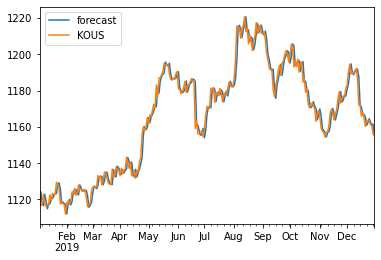

In [ ]:
# 전혀의미없지만 이런함수도 있다. 학습한데이터와 같은 데이터를 테스트로 돌려서 예측 plot을 그리는것인데 의미가....
model_fit.plot_predict()
plt.show()

# train/ test split

arima계열 데이터는 데이터가 너무많으면 예측하기에 별로안좋다??

In [ ]:
train = df.iloc[0:30]
test = df.iloc[30:35]

In [ ]:
model = ARIMA(train, order = (2,1,2), freq = 'B')
model_fit = model.fit(trend = 'nc')
model_fit.forecast(5, alpha = 0.05)

(array([1122.71126571, 1123.35492383, 1123.72752319, 1123.72485447,
        1123.51270791]),
 array([3.55653204, 4.20720366, 4.80873165, 5.7449708 , 6.93432529]),
 array([[1115.740591  , 1129.68194043],
        [1115.10895618, 1131.60089147],
        [1114.30258234, 1133.15246404],
        [1112.46491861, 1134.98479032],
        [1109.92168007, 1137.10373574]]))

첫 번째 array : 예측 값

두 번째 array : 표준에러

세 번째 array : 신뢰구간 [하한, 상한]

In [ ]:
fc, se, coef = model_fit.forecast(5, alpha = 0.05)

In [ ]:
# 예측값 인덱스 넣기
fc_data = pd.Series(fc, index = test.index)

# 신뢰구간 인덱스 넣기
lower_data = pd.Series(coef[:,0], index = test.index)
upper_data = pd.Series(coef[:,1], index = test.index )

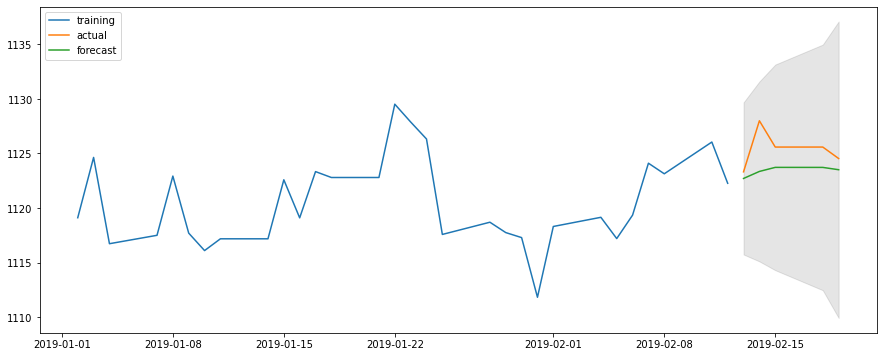

In [ ]:
# VIZ
plt.figure(figsize =(15, 6))
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(fc_data, label = 'forecast')
plt.fill_between(test.index, lower_data, upper_data, color = 'black', alpha = 0.1)
plt.legend(loc = 'upper left')
plt.show()

ARIMA 모형의 한계는 기존의 패턴으로 예측하기에 외부 요인으로 튄경우를 예측하지 못하는데 VAR(Vector Auto Regression)같은 모델을 활용하여 Multivariate time series forecasting 을 해야한다.